### General workflow:
1. export points from OpendTect for each formation (BFSZ, Montney, Debolt)
2. assign (manually) which point correspond to each fault
2. calculate offset = difference between the 1) intersection of line perpendicular to strike (assumed to be the point of shortest distance to the mapped fault) and 2) interpreted location (point on lithoprobe profile)
3. translate shapefile by that difference

Ideas: **1)** add column *orientation* (SE-NW, N-S) **2)**
put in one big project together with visualization of lithoprobe lines etc

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [3]:
faults_BFSZ_file = os.path.join("data", "Mei_2009_faults_BFSZ.shp")
faults_montney_file = os.path.join("data", "Mei_2009_faults_Montney.shp")
faults_debolt_file = os.path.join("data", "Mei_2009_faults_Debolt.shp")

In [4]:
faults_BFSZ = gpd.read_file(faults_BFSZ_file)
faults_montney = gpd.read_file(faults_montney_file)
faults_debolt = gpd.read_file(faults_debolt_file)

In [66]:
lithoprobe = gpd.read_file("data/lithoprobe.geojson")
lithoprobe = lithoprobe.to_crs(faults_debolt.crs)

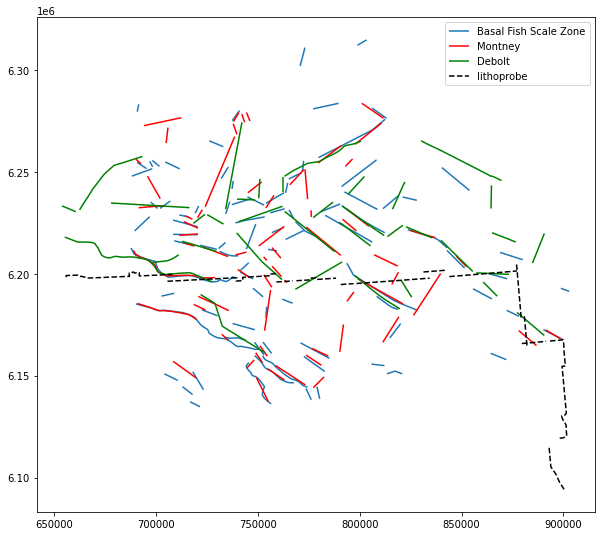

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
faults_BFSZ.plot(ax=ax, label='Basal Fish Scale Zone')
faults_montney.plot(ax=ax, color='r', label='Montney')
faults_debolt.plot(ax=ax, color='g', label='Debolt')
lithoprobe.plot(ax=ax, label="lithoprobe", color='k', linestyle='dashed')
ax.legend();

Reference datum for NAD83 coordinates = GRS80

In [6]:
from geographiclib.geodesic import Geodesic

def coords(geom):
    return list(geom.coords)

def calculate_azimuth(lat1, lon1, lat2, lon2):
    azi = Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)['azi1']
    return azi
    
def create_coords_azi(df):
    df['lat1'] = df.apply(lambda row: coords(row.geometry)[0][1], axis=1)
    df['lon1'] = df.apply(lambda row: coords(row.geometry)[0][0], axis=1)
    df['lat2'] = df.apply(lambda row: coords(row.geometry)[-1][1], axis=1)
    df['lon2'] = df.apply(lambda row: coords(row.geometry)[-1][0], axis=1)
    df['azi'] = df.apply(lambda row: calculate_azimuth(row.lat1, row.lon1, row.lat2, row.lon2), axis=1)
    return df         

In [7]:
faults_debolt['geometry'] = faults_debolt['geometry'].to_crs(4326)

faults_debolt = create_coords_azi(faults_debolt)

# change crs back to NAD83
faults_debolt = faults_debolt.to_crs(26910) 

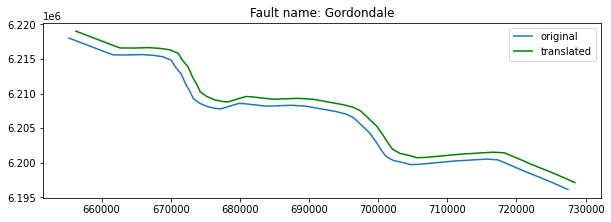

In [8]:
# example of GaoPandas.GeoSeries.translate

orig = gpd.GeoSeries(faults_debolt.geometry[0])
trans = gpd.GeoSeries(faults_debolt.geometry[0]).translate(1000,1000)

fig, ax = plt.subplots(figsize=(10,10))
orig.plot(ax=ax,label='original')
trans.plot(ax=ax,color='g', label='translated')
ax.set_title("Fault name: " + faults_debolt.Fault_name[0])
ax.legend();

In [9]:
print("Faults in the Debolt shapefile:")
print(faults_debolt.Fault_name.unique())

Faults in the Debolt shapefile:
['Gordondale' 'Saddle Hills' 'Bear Canyon' 'Tangent (Normandville)'
 'Rycroft' 'George' 'Dunvegan (Belloy)' 'Berwyn' 'Unknown' 'Hines Creek'
 'Whitemud' 'Fairview' 'Bluesky' 'Farmington' 'Josephine Creek'
 'Peace River' 'Boundary Lake']


Let's translate the fault using the knowledge from interpreted seismic - Berwyn fault

In [10]:
import shapely
from shapely import geometry

berwyn_faults = faults_debolt[faults_debolt['Fault_name'] == 'Berwyn']

berwyn_faults_merged = geometry.MultiLineString([p for p in berwyn_faults.geometry])

In [11]:
# use ready shapefile
intersect_point = gpd.read_file("data/example_intersection_point.shp")
print(intersect_point[['Fault_name','geometry']])

   Fault_name                        geometry
0  Berwyn_12B  POINT (774587.590 6196968.350)


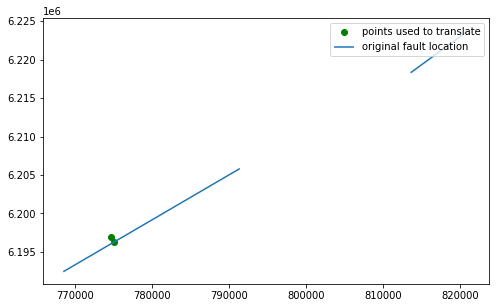

In [12]:
from shapely.ops import nearest_points

# nearest_points() returns a tuple of:
# 1st item = geometry of origin point 
# 2nd item (at index 1) = is the actual nearest geometry from the destination points.from shapely import geometry,ops

closest_points = [o.wkt for o in nearest_points(berwyn_faults_merged, intersect_point.geometry[0])]

P1 = shapely.wkt.loads(closest_points[0])
P2 = shapely.wkt.loads(closest_points[1])
points = [P1, P2]

fig, ax = plt.subplots(figsize=(8,8))

xs = [point.x for point in points]
ys = [point.y for point in points]

plt.scatter(xs, ys,color='g',label='points used to translate')
berwyn_faults.plot(ax=ax, label="original fault location")

ax.legend();

In [13]:
# calculate fault offset

xoffset = P2.x - P1.x
yoffset = P2.y - P1.y

print(xoffset, yoffset)

-410.9091249763733 703.374378008768


In [14]:
berwyn_faults_shifted = berwyn_faults.geometry.apply(lambda x: shapely.affinity.translate(x, xoff=xoffset, yoff=yoffset))

In [15]:
lithoprobe = gpd.read_file("data/lithoprobe.geojson")
lithoprobe = lithoprobe.to_crs(26910)

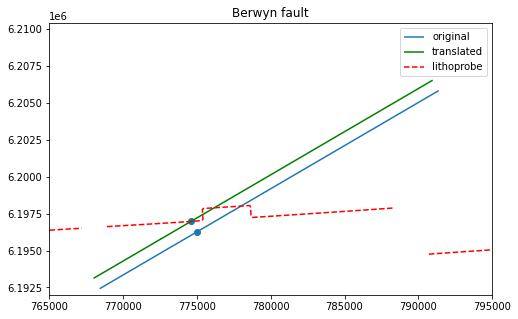

In [65]:

fig, ax = plt.subplots(figsize=(10,5))

berwyn_faults.plot(ax=ax,label='original')
berwyn_faults_shifted.plot(ax=ax,color='g', label='translated')
lithoprobe.plot(ax=ax, color='r', linestyle='dashed', label='lithoprobe')

ax.set_ylim(6162413.644, 6232413.644)
ax.set_xlim(700000, 850000)

ax.set_ylim(6192000.644, 6210413.644)
ax.set_xlim(765000, 795000)
ax.set_title(berwyn_faults["Fault_name"].iloc[0] + " fault")

ax.scatter(xs, ys)
ax.legend();

In [136]:
# use ready shapefile
debolt_points = gpd.read_file("data/debolt_intersection_points.shp")

debolt_points.rename(columns={'field_1': 'X', 'field_2':'Y'}, inplace=True)
debolt_points.drop(columns=['field_3','field_4','field_5','field_6','field_7','field_8'],inplace=True)

debolt_points.dropna(inplace=True)
debolt_points = debolt_points[~debolt_points['Fault_name'].str.contains("Unknown")]

for fault_index, fault_row in faults_debolt.iterrows():
    for point_index, point_row in debolt_points.iterrows():
        if fault_row['Fault_name'] in point_row['Fault_name']:
            print(fault_row['Fault_name'],point_row['Fault_name'])
        

Gordondale Gordondale_11B
Gordondale Gordondale_11B
Gordondale Gordondale_11B
Gordondale Gordondale_11A
Rycroft Rycroft_12A
Berwyn Berwyn_12B
Berwyn Berwyn_12B


alternative example using cKDTree from Scipy

In [145]:
# Create geodataframe with point intersections (example for Debolt picks saved in .dat file)

import pandas as pd
from shapely.geometry import Point

debolt_points_file = os.path.join("data", "debolt_fault_intersections.dat")

picks_df = pd.read_csv(debolt_points_file,
            header=None, sep='\t', engine='python')
picks_df.rename(columns={0: 'X', 1:'Y', 2:'depth'}, inplace=True)

picks_df['geometry'] = picks_df.apply(lambda x: Point((float(x.X), float(x.Y))), axis=1)
picks_gdf = gpd.GeoDataFrame(picks_df, geometry='geometry', crs=26711)
picks_gdf.to_crs(26910)

picks_gdf.head()

,X,Y,depth,3,4,5,6,7,geometry
0,427755.312500,6.185368e+06,1512.199417,1,0,0,24776,14537,POINT (427755.312 6185368.414)
1,503214.109375,6.155639e+06,1436.097394,1,0,0,3,1462,POINT (503214.109 6155638.535)
2,310045.580078,6.198693e+06,1763.076492,1,0,0,14,1315,POINT (310045.580 6198692.883)
3,372623.085938,6.193151e+06,1546.253305,1,0,0,15,4204,POINT (372623.086 6193150.848)
4,359437.562500,6.193560e+06,1581.611861,1,0,0,15,3548,POINT (359437.562 6193559.891)


In [146]:
import geopandas as gpd
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree
from shapely.geometry import Point

gpd1 = gpd.GeoDataFrame([['John', 1, Point(1, 1)], ['Smith', 1, Point(2, 2)],
                         ['Soap', 1, Point(0, 2)]],
                        columns=['Name', 'ID', 'geometry'])
gpd2 = gpd.GeoDataFrame([['Work', Point(0, 1.1)], ['Shops', Point(2.5, 2)],
                         ['Home', Point(1, 1.1)]],
                        columns=['Place', 'geometry'])

def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

ckdnearest(gpd1, gpd2)

,Name,ID,geometry,Place,dist
0,John,1,POINT (1.00000 1.00000),Home,0.1
1,Smith,1,POINT (2.00000 2.00000),Shops,0.5
2,Soap,1,POINT (0.00000 2.00000),Work,0.9


Merge faults with the same name, move them by the distance & angle https://stackoverflow.com/questions/41379482/how-to-translate-a-point-to-specified-distance-at-a-specified-angle

work on geopackage

In [152]:
# import fiona

# # with fiona.open('data/test.gpkg') as layers:
# #     print(layers)
# # #     for feature in layers:
# # #         print(feature['geometry'])

# # No need to pass "layer='etc'" if there's only one layer
# with fiona.open('data/test.gpkg', layer='Mei_2009_faults_BFSZ') as layer:
#     print(type(layer))
# #     for feature in layer:
# #         print(type(feature.geometry))
# #         print(feature['geometry'])


# import pprint
# import fiona
# with fiona.open('data/test.gpkg') as src:
#     pprint.pprint(src[2])

In [153]:
!jupyter nbconvert shapefile_operations.ipynb --to html

[NbConvertApp] Converting notebook shapefile_operations.ipynb to html
[NbConvertApp] Writing 796100 bytes to shapefile_operations.html
